Есть векторы x, y. Будем приближать y векторами, которые получаются из x

In [26]:
import numpy as np

In [27]:
import copy

In [28]:
import scipy.io
mat = scipy.io.loadmat('/Users/nikitakocherin/Downloads/BlackBoxData.mat')

In [29]:
x = mat['x'][0]
y = mat['y'][0]

In [30]:
x = (x / np.linalg.norm(x))
y = (y / np.linalg.norm(y))

In [31]:
def generate_first_monom_dict(I, x):
    def generate_first_mon(bias, x):
        if bias == 0:
                return x
        base = np.zeros(len(x), dtype='complex')
        if bias < 0:
            for i in range(-bias, len(x)):
                base[i] = x[i + bias]
        elif bias > 0:
            for i in range(len(x) - bias):
                base[i] = x[i + bias]
        return base
    result = []
    for i in range(-I, I + 1):
        result.append(generate_first_mon(i, x))
    return result

In [32]:
#Функция для генерации словаря мономов, из которых потом будет состоять каждый элемент настоящего словаря
# I -- максимальный модуль сдвига(bias)
# |d|
#нужно брать модуль при генерации
def generate_monom_dict(I, D, x):
    def generate_mon(bias, degree, x):
        if bias == 0:
            return np.power(np.absolute(x), degree)
        base = np.zeros(len(x), dtype='complex')
        if bias < 0:
            for i in range(-bias, len(x)):
                base[i] = x[i + bias]
        elif bias > 0:
            for i in range(len(x) - bias):
                base[i] = x[i + bias]
        return np.power(np.absolute(base), degree)
    result = []
    for i in range(-I, I + 1):
        for j in range(D + 1):
            result.append(generate_mon(i, j, x))
    return result

#M -- количество мономов в одном элементе словаря, не считая первого с нулевой степенью
def generate_real_dict(I, D, M, x):
    monom_dict = generate_monom_dict(I, D, x)
    result = []
    def recursive_generate(monom_dict, deep, x):
        if deep == 1:
            return monom_dict
        else:
            to_mult = recursive_generate(monom_dict, deep - 1, x)
            result = []
            first_mon = monom_dict
            for i in first_mon:
                for j in to_mult:
                    result.append(i * j)
            return result
    first_mon = generate_first_monom_dict(I, x)
    to_mult = recursive_generate(monom_dict, M, x)
    for i in first_mon:
        for j in to_mult:
            k = i * j
            k = k / np.linalg.norm(k)
            result.append(k)
    return result    

In [59]:
#y -- приближаем с помощью x
#u -- остаток, изначальный остаток -- y
#
def approximate(x, y, I, D, M, flag=True):
    my_dict = generate_real_dict(I, D, M, x)
    u_n = y
    iter = 0
    v_arr = []
    v_norm = []
    norm_u_n_prev = 0
    u_n_prev = copy.deepcopy(u_n)
    while(np.linalg.norm(u_n) > 0.01 and iter < 500):
        v_norm.append(np.linalg.norm(u_n))
        if abs(np.linalg.norm(u_n) - norm_u_n_prev) < 0.0000001:
            break
        norm_u_n_prev = np.linalg.norm(u_n)
        v_n1 = None
        val = 0
        for i in my_dict:
            s = np.absolute(np.vdot(u_n, i))
            nor = abs(s)
            if nor > val:
                v_n1 = i
                val = nor
        h_n1_wave = copy.deepcopy(v_n1)
        if flag:
            for i in v_arr:
                #print("iter", iter)
                #print(np.vdot(v_n1, i), np.vdot(i, v_n1))
                h_n1_wave = h_n1_wave - np.vdot(i, v_n1) * i
        h_n1 = h_n1_wave / np.linalg.norm(h_n1_wave)
        v_arr.append(h_n1)
        u_n = u_n - np.vdot(h_n1, u_n) * h_n1 #поменял
        iter += 1
        if iter % 20 == 0:
            print(np.linalg.norm(u_n))
    print(np.linalg.norm(u_n), "iter:", iter)
    return v_norm

In [34]:
#approximate(x, y, 2, 2, 2)

теперь не храним все в памяти

In [35]:
def multiplicate(count, monom_dict):
    if count == 1:
        for i in monom_dict:
            yield i
    elif count == 2:
        for i in monom_dict:
            for j in monom_dict:
                yield i * j
    elif count == 3:
        for i in monom_dict:
            for j in monom_dict:
                for k in monom_dict:
                    yield i * j * k
    

In [36]:
def generate_real_dict_generator(I, D, M, x):
    monom_dict = generate_monom_dict(I, D, x)
    first_mon = generate_first_monom_dict(I, x)
    for i in first_mon:
        to_mult = multiplicate(M, monom_dict)
        for j in to_mult:
            k = i * j
            k = k / np.linalg.norm(k)
            yield k    

In [108]:
#y -- приближаем с помощью x
#u -- остаток, изначальный остаток -- y
#
def approximate_without_saving(x, y, I, D, M, flag=True):
    u_n = y
    iter = 0
    v_arr = []
    vector_norm = []
    norm_u_n_prev = 0
    u_n_prev = copy.deepcopy(u_n)
    while(np.linalg.norm(u_n) > 0.01 and iter < 1000):
        vector_norm.append(np.linalg.norm(u_n))
        if abs(np.linalg.norm(u_n) - norm_u_n_prev) < 0.0000001:
            break
        norm_u_n_prev = np.linalg.norm(u_n)
        v_n1 = None
        val = 0
        my_dict = generate_real_dict_generator(I, D, M, x)
        for i in my_dict:
            s = np.absolute(np.vdot(u_n, i))
            nor = abs(s)
            if nor > val:
                v_n1 = i
                val = nor
        h_n1_wave = copy.deepcopy(v_n1)
        if flag:
            for i in v_arr:
                #print("iter", iter)
                #print(np.vdot(v_n1, i), np.vdot(i, v_n1))
                h_n1_wave = h_n1_wave - np.vdot(i, v_n1) * i
        h_n1 = h_n1_wave / np.linalg.norm(h_n1_wave)
        v_arr.append(h_n1)
        u_n = u_n - np.vdot(h_n1, u_n) * h_n1 #поменял
        iter += 1
        if iter % 20 == 0:
            print(np.linalg.norm(u_n))
    print(np.linalg.norm(u_n), "iter:", iter)
    return vector_norm

In [38]:
#approximate_without_saving(x, y, 2, 2, 2)

In [39]:
D = generate_real_dict(2, 2, 2, x)

In [40]:
a, b, c = np.random.randint(len(D) - 1, size=3)

In [41]:
first = D[a]
second = D[b]
third = D[c]

In [42]:
alpha_1, alpha_2, alpha_3 = np.random.rand(3) * 2 - 1

In [43]:
y_test = alpha_1 * first + alpha_2 * second + alpha_3 * third
y_test =  y_test/np.linalg.norm(y_test)

In [44]:
#approximate(x, y_test, 2, 2, 2)

In [45]:
#approximate(x, y, 1, 2, 2)

In [46]:
#approximate(x, y, 2, 2, 2, flag=False)

In [47]:
v_norm = approximate_without_saving(x, y, 3, 2, 2)

0.13911381760262165
0.11937814651711774
0.11502351395402428
0.09409815550469312
0.08564381896524514
0.07955983522539876
0.0779126085582744
0.07255819904024753
0.07130661884453837
0.07001191843202584
0.06919474563828483
0.06876952718095716
0.06840592227302744
0.06509464072805282
0.06417494363871003
0.06378586924708542
0.06331615329139886
0.06262494618474024
0.06195938693529716
0.061208844147770024
0.06071228860064041
0.05568987463047785
0.05459543365514853
0.0541896928298276
0.053354112811331775
0.05310463445426996
0.052961014236958134
0.052854539943995534
0.05248669042559051
0.052259832675229094
0.051897556569435656
0.05169610619643784
0.05163402987482135
0.05145270060313701
0.05133207160174644
0.05121979470047145
0.05108862034671024
0.0510093306750031
0.050886883287338175
0.05049383803054828
0.05034856760926862
0.050158059604148764
0.050067223663627564
0.049912942347861894
0.04981601740788317
0.04975073173117929
0.049692652487168074
0.049599538962617144
0.04935434493697999
0.048846795

In [60]:
v_norm_222 = approximate(x, y, 2, 2, 2)

0.06538489239939564
0.05583293902304306
0.05003677189411938
0.04739865688126172
0.04217663780605666
0.03645991573276225
0.03470083535171343
0.03308249723319386
0.03222761634072152
0.03144936901175746
0.031121265956730707
0.030736246638154663
0.03059678039165769
0.030519390722423607
0.030508246876823138 iter: 286


In [64]:
v_norm_232 = approximate_without_saving(x, y, 2, 3, 2)

0.13911381760262165
0.1229446224562549
0.11009922309542405
0.10572996982389778
0.09590690750378324
0.09259058449084226
0.0881750084365688
0.06888249944215287
0.06765509820097566
0.06340801957967318
0.06260951967135846
0.06111276595205105
0.06028874500378128
0.05746386721309444
0.057024086415436
0.05566791929212983
0.055452771294960075
0.053892733051195824
0.053590541720781044
0.05294115954557857
0.05258325083095587
0.05232901436428824
0.052176218318609406
0.051809128976251076
0.050856283073977715
0.05062964469195074
0.05039855349410793
0.050090183489110256
0.0497142990752793
0.04895243750411572
0.04859670316523872
0.048462689634910024
0.048319081885425365
0.04796624525410143
0.04737423394323471
0.047049670256996995
0.04685867307428161
0.04615222907699211
0.04601645547729503
0.04581409329763775
0.045502287862562676
0.045304739148731114
0.0451924568345309
0.04509117540568882
0.04499145250280217
0.04486679525180858
0.0441107762536918
0.04264350114659726
0.04248687640766409
0.0412040965050

In [65]:
v_norm_223 = approximate_without_saving(x, y, 2, 2, 3)

0.13911381760262165
0.11274784302150653
0.10722039979266676
0.10247340419657712
0.09854694168384809
0.09640380860659586
0.09463488385429966
0.08871684970862753
0.08092360000034152
0.07878382289089945
0.07662532577972815
0.07588976210791214
0.06865652855528458
0.0679203397466515
0.06668674055737385
0.0655164679553632
0.059869579793257764
0.0595349895728192
0.05895995147249168
0.057753737066707785
0.057227980347566355
0.05662420615204797
0.056180952810978936
0.05574925632621334
0.05442502058596935
0.05415657153222248
0.05385829074124297
0.0533778495179264
0.053137743884506636
0.05277667592993105
0.05222238258810664
0.05201214906168539
0.05176584141574819
0.05140027229857686
0.050362853497347516
0.05007449102106909
0.04978782967970208
0.04961753003882563
0.04917724420274036
0.04892203988868915
0.048812188222224
0.04826216262575509
0.04808097487530051
0.047351174623937585
0.047186981891313116
0.046847766063506116
0.04659425058609231
0.04653409988291893
0.04598462936603856
0.045859260816505

In [66]:
v_norm_322 = approximate_without_saving(x, y, 3, 2, 2)

0.13911381760262165
0.11937814651711774
0.11502351395402428
0.09409815550469312
0.08564381896524514
0.07955983522539876
0.0779126085582744
0.07255819904024753
0.07130661884453837
0.07001191843202584
0.06919474563828483
0.06876952718095716
0.06840592227302744
0.06509464072805282
0.06417494363871003
0.06378586924708542
0.06331615329139886
0.06262494618474024
0.06195938693529716
0.061208844147770024
0.06071228860064041
0.05568987463047785
0.05459543365514853
0.0541896928298276
0.053354112811331775
0.05310463445426996
0.052961014236958134
0.052854539943995534
0.05248669042559051
0.052259832675229094
0.051897556569435656
0.05169610619643784
0.05163402987482135
0.05145270060313701
0.05133207160174644
0.05121979470047145
0.05108862034671024
0.0510093306750031
0.050886883287338175
0.05049383803054828
0.05034856760926862
0.050158059604148764
0.050067223663627564
0.049912942347861894
0.04981601740788317
0.04975073173117929
0.049692652487168074
0.049599538962617144
0.04935434493697999
0.048846795

In [67]:
v_norm_332 = approximate_without_saving(x, y, 3, 3, 2)

0.13911381760262165
0.11937814651711774
0.10510257413204228
0.09826428185639538
0.09445765319364141
0.08939088656464406
0.0856870117490951
0.08427975830002414
0.08338801671143505
0.08281788644675135
0.08086858359333697
0.07960602386845639
0.07897268353096128
0.07848798570534903
0.07781115044184128
0.07630794265047923
0.0753791443355181
0.06127366673131308
0.05969384260416568
0.05865545232212162
0.058010442177212365
0.0577507636514265
0.05739222748387576
0.05674499961923376
0.0558012887966046
0.055027427488845475
0.05473047183299996
0.054464125746518176
0.054171552868436404
0.05394407098070777
0.05369530873865807
0.053600155683555584
0.05348580663406596
0.053347310081851625
0.0519359347231166
0.051487358642591005
0.05114067827025735
0.0509972115800425
0.04983122446967403
0.04961627717455034
0.049076220374983416
0.048873191011765287
0.04859042455002395
0.048252182846348204
0.04772206313666423
0.04759218485319032
0.047374103545360036
0.047002280611101045
0.046949612612550845
0.04682830149

In [72]:
v_norm_332.pop(0)

0.9999999999999937

In [62]:
v_norm_222

[0.1616854015186667,
 0.13911381760262165,
 0.12717273011368913,
 0.12516691107118616,
 0.12153994108814103,
 0.11862003309164108,
 0.08874101150396628,
 0.08784960743674877,
 0.08650847767603932,
 0.08027775506328265,
 0.07914466559356552,
 0.07134188538716915,
 0.07097713012643361,
 0.06961139872901816,
 0.06913415476745863,
 0.06843870625487347,
 0.06799076395964018,
 0.06735757895005927,
 0.06603162612242335,
 0.06538489239939564,
 0.06521437872309538,
 0.06376534714230203,
 0.06339004408997674,
 0.06241636952346754,
 0.06110861449738421,
 0.06098228030779255,
 0.06076577011857419,
 0.05825420561342692,
 0.05818959810420919,
 0.058026803942969024,
 0.05786779466524003,
 0.05778626743746573,
 0.057690199043966536,
 0.0575291876966501,
 0.05739585820658307,
 0.05732906915647229,
 0.05662404037102521,
 0.05643900575903864,
 0.056349552148907134,
 0.05583293902304306,
 0.0556290380925224,
 0.05548780806609381,
 0.05518680269606433,
 0.054872278494481765,
 0.05472774417181829,
 0.054562

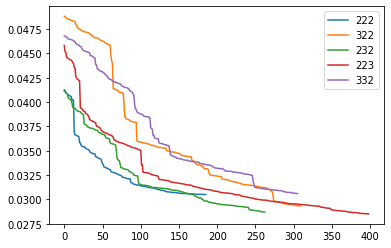

In [83]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots() 
ax.plot(v_norm_222[100:], label='222')
ax.plot(v_norm_322[100:], label='322')
ax.plot(v_norm_232[100:], label='232')
ax.plot(v_norm_223[100:], label='223')
ax.plot(v_norm_332[100:], label='332')
ax.legend()

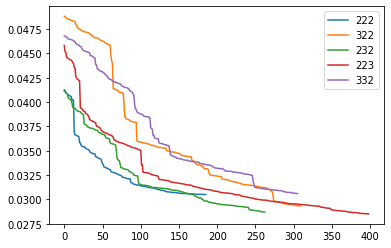

In [86]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots() 
ax.plot(v_norm_222[100:], label='222')
ax.plot(v_norm_322[100:], label='322')
ax.plot(v_norm_232[100:], label='232')
ax.plot(v_norm_223[100:], label='223')
ax.legend()

In [101]:
s = 0
for i in generate_real_dict_generator(3, 4, 2, x):
    s += 1
print(s)

8575


In [105]:
%%time
u_norm_222 = approximate_without_saving(x, y, 2, 2, 2)

0.13911381760262165
0.12516691107118616
0.11862003309164108
0.08784960743674877
0.08027775506328265
0.07134188538716915
0.06961139872901816
0.06843870625487347
0.06735757895005927
0.06538489239939564
0.06376534714230203
0.06241636952346754
0.06098228030779255
0.05825420561342692
0.058026803942969024
0.05778626743746573
0.0575291876966501
0.05732906915647229
0.05643900575903864
0.05583293902304306
0.05548780806609381
0.054872278494481765
0.05456263048429076
0.05418442630493983
0.053938668664968444
0.05305855441625208
0.05274958830031486
0.05246355188244081
0.05045488748755005
0.05003677189411938
0.04945553150504439
0.04929282886509529
0.04879807249098625
0.04851276123895898
0.04836853920938065
0.04826527160449258
0.04802474097540834
0.04786081896098998
0.04765053856987971
0.04739865688126172
0.04691397774825864
0.04687194616296556
0.04682980121786121
0.04677377505656113
0.04663162193040082
0.04647883384608395
0.046262660724428896
0.04597621798336659
0.04489059934174814
0.042176637806056

In [109]:
%%time
u_norm_322 = approximate_without_saving(x, y, 3, 2, 2)

0.07001191843202584
0.061208844147770024
0.052259832675229094
0.05049383803054828
0.04884679570870253
0.04753283749648456
0.04665137789257964
0.045866555997059404
0.03849215482234623
0.0359102269377828
0.035482296336579754
0.03490743428674491
0.03444720799533376
0.033445198077484015
0.03241267864028424
0.03186590161253933
0.03149559515785577
0.0312371187159607
0.029732503405986804
0.02943060395661682
0.02917660480353914
0.029014639579272687
0.02891847063409081
0.028800343237186953
0.028676376395090252
0.02863148993875493
0.028550205640852942
0.02846821477434364
0.028431918906190724
0.02830494385247371
0.028297240402747677 iter: 609
CPU times: user 1h 21s, sys: 1min 16s, total: 1h 1min 38s
Wall time: 1h 1min 39s


In [110]:
%%time
u_norm_232 = approximate_without_saving(x, y, 2, 3, 2)

0.06340801957967318
0.05294115954557857
0.04895243750411572
0.04581409329763775
0.041204096505075456
0.0390550771454026
0.03721061801891924
0.03621513663597361
0.033117436806105245
0.03154886503271468
0.031218075296909727
0.03101640474307857
0.030651283158647062
0.030149204919643475
0.029570380697486586
0.02938245527404189
0.02919347300134791
0.028727305349862457
0.028482854299862866
0.026672561688625716
0.026248335888725573
0.0260480677546165
0.025892810877166404
0.02545275731115783
0.02538530093791104
0.025368534633881692 iter: 504
CPU times: user 33min 39s, sys: 39.2 s, total: 34min 18s
Wall time: 34min 19s


In [116]:
%%time
u_norm_223 = approximate_without_saving(x, y, 2, 2, 3)

0.07878382289089945
0.057753737066707785
0.05277667592993105
0.04892203988868915
0.04585926081650537
0.042241997748282425
0.037934925840770364
0.03662983800759774
0.035699997945800255
0.03505275789813954
0.0324680584287824
0.03181198071814508
0.031518036293216575
0.031172147709615027
0.03084037323192182
0.03059919461751369
0.030251300649258676
0.029946045268632374
0.02974480993072133
0.029552667134277403
0.029407269657659482
0.02918337517275898
0.028829175880716647
0.0286489959199083
0.028509204904593397
0.027239553952633448
0.02626390728444632
0.02612305510990501
0.026005094666019583
0.025873665701510843
0.02566960800150546
0.025550522988022385
0.025460158070453074
0.02536510654559412
0.025284528040895687
0.025207671091528015
0.025086543284291846
0.02495844244368532
0.024874180132633796
0.024827853739975755
0.024720385001819053
0.024667972243641482
0.024617595685235773
0.024586332474193954
0.02456616719414578 iter: 897
CPU times: user 7h 25min 56s, sys: 7min 33s, total: 7h 33min 30s
W

In [115]:
s = 0
for i in generate_real_dict_generator(2, 2, 3, x):
    s += 1
print(s)

16875


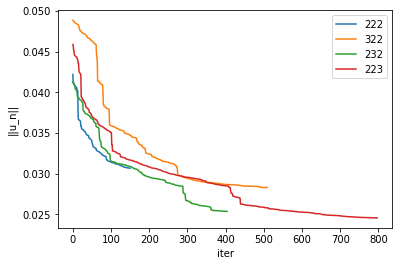

In [120]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots() 
ax.plot(u_norm_222[100:], label="222")
ax.plot(u_norm_322[100:], label="322")
ax.plot(u_norm_232[100:], label="232")
ax.plot(u_norm_223[100:], label="223")

ax.set_xlabel('iter')
ax.set_ylabel('||u_n||')
ax.legend()